# NetCDF Test

In [1]:
from netCDF4 import Dataset

In [2]:
rootgrp = Dataset('../Data/NCEP-NCAR Reanalysis (R1)/Monthly Surface Temperatures/air.mon.mean.nc',mode='r')

In [3]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [4]:
ncdump(rootgrp)

NetCDF Global Attributes:
	description: 'Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values'
	platform: 'Model'
	Conventions: 'COARDS'
	NCO: '20121012'
	history: 'Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc\nThu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc\nMon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc\n/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc\ncreated 95/03/13 by Hoop (netCDF2.3)\nConverted to chunked, deflated non-packed NetCDF4 2014/09'
	title: 'monthly mean air.sig995 from the NCEP Reanalysis'
	References: 'http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html'
	dataset_title: 'NCEP-NCAR

(['description',
  'platform',
  'Conventions',
  'NCO',
  'history',
  'title',
  'References',
  'dataset_title'],
 ['lat', 'lon', 'time'],
 ['lat', 'lon', 'time', 'air'])

In [5]:
print(rootgrp.variables['lon'][-1])

357.5


# Basemap and Map Plotting
So now that we have netcdf working, let's figure out how to make maps!

In [6]:
import mpl_toolkits.basemap as bmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import colorcet as cc

In [7]:
# extract variables from reanalysis file
lons = rootgrp.variables['lon'][:]
lats = rootgrp.variables['lat'][:]
times = rootgrp.variables['time'][:]
air = rootgrp.variables['air'][:]

In [8]:
# set indicies for July 2019 and Dec 2019
time_idx = [857,863]

# convert times (hours since 1800-01-01) to normal date format
dates = [dt.date(1800,1,1) + dt.timedelta(hours=t) for t in times]
current_dates = [dates[idx] for idx in time_idx] 

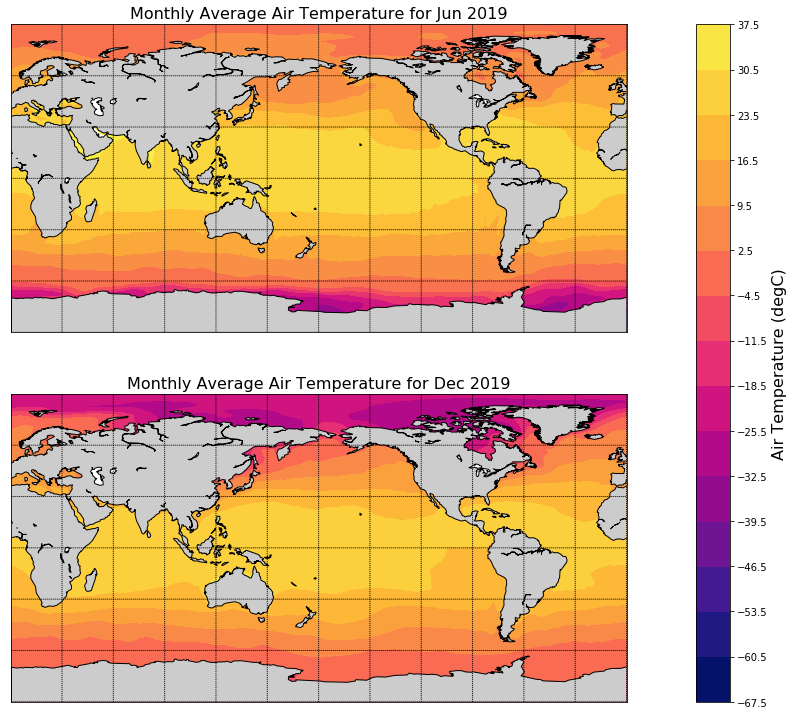

In [91]:
# find min/max temperature between both plots
tempmin = min(np.min(air[time_idx[0]]), np.min(air[time_idx[1]]))
tempmax = max(np.max(air[time_idx[0]]), np.max(air[time_idx[1]]))
temp_levels = np.arange(tempmin, tempmax, 7)

# setup figure
fig, AX = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_facecolor('white')
fig.tight_layout()

for idx in np.arange(2):
    # setup map projection
    m = bmp.Basemap(projection='cyl', resolution='c', lon_0=-180, lat_0=0,
                    llcrnrlon=-360, llcrnrlat=-90, urcrnrlon=0, urcrnrlat=90)
    m.drawcoastlines(ax=AX[idx])
    m.fillcontinents(ax=AX[idx])
    m.drawparallels(np.arange(-90, 90, 30), ax=AX[idx])
    m.drawmeridians(np.arange(0, 360, 30), ax=AX[idx])

    # add 360 degree lon point so map is continuous
    air_cyc, lons_cyc = bmp.addcyclic(air[time_idx[idx], :, :], lons)
    # Shift the grid so lons go from -180 to 180 instead of 0 to 360.
    air_shift, lons_shift = bmp.shiftgrid(0, air_cyc, lons_cyc, start=False)

    # because lats, lons not the same length, create grid
    lons2d, lats2d = np.meshgrid(lons_shift, lats)

    x, y = m(lons2d, lats2d)
    cs = m.contourf(x, y, air_shift[:, :], latlon=False, ax=AX[idx],
                    levels=temp_levels, cmap=cc.cm.linear_bmy_10_95_c71)
    AX[idx].set_title("Monthly Average Air Temperature for %s" %
                      (current_dates[idx].strftime("%b %Y")), fontsize=16)

# color bar
fig.subplots_adjust(hspace=.2)
cbar = fig.colorbar(cs, ax=AX.flat, ticklocation='left', ticks=temp_levels)
cs.set_clim(tempmin, tempmax)
cbar.set_label("%s (%s)" % (
    rootgrp.variables['air'].var_desc, rootgrp.variables['air'].units), fontsize=16)

Okay, bizare issue. When 'lon_0 > 0' the map projection is (usually) fucked up. IDK why. And when it is set to a negative value, I can't seem to shift the longitudes and temperatures so that they plot correctly. I can get it to work using mercator or orthogonal projection, but using any equal area projection messes things up.